In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os

In [2]:
# path=r'C:\Users\berid\OneDrive\Desktop\mydata\google_cyclistic_bike_share\\'
# df=pd.DataFrame()
# for file in os.listdir(path):
    # data=pd.read_csv(path+file)
    # df=pd.concat([df,data],ignore_index=True)

In [3]:
df=pd.read_csv(r'C:\Users\berid\OneDrive\Desktop\mydata\google_cyclistic_bike_share\\202207-divvy-tripdata.csv')

In [4]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,954144C2F67B1932,classic_bike,2022-07-05 08:12:47,2022-07-05 08:24:32,Ashland Ave & Blackhawk St,13224,Kingsbury St & Kinzie St,KA1503000043,41.907066,-87.667252,41.889177,-87.638506,member
1,292E027607D218B6,classic_bike,2022-07-26 12:53:38,2022-07-26 12:55:31,Buckingham Fountain (Temp),15541,Michigan Ave & 8th St,623,41.869621,-87.623981,41.872773,-87.623981,casual
2,57765852588AD6E0,classic_bike,2022-07-03 13:58:49,2022-07-03 14:06:32,Buckingham Fountain (Temp),15541,Michigan Ave & 8th St,623,41.869621,-87.623981,41.872773,-87.623981,casual
3,B5B6BE44314590E6,classic_bike,2022-07-31 17:44:21,2022-07-31 18:42:50,Buckingham Fountain (Temp),15541,Woodlawn Ave & 55th St,TA1307000164,41.869621,-87.623981,41.795264,-87.596471,casual
4,A4C331F2A00E79E0,classic_bike,2022-07-13 19:49:06,2022-07-13 20:15:24,Wabash Ave & Grand Ave,TA1307000117,Sheffield Ave & Wellington Ave,TA1307000052,41.891466,-87.626761,41.936253,-87.652662,member


# Clean data

In [5]:
df.isna().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    112031
start_station_id      112031
end_station_name      120951
end_station_id        120951
start_lat                  0
start_lng                  0
end_lat                  947
end_lng                  947
member_casual              0
dtype: int64

In [6]:
df=df[df.isna().any(axis=1)==False] # clean data from NaN values
df=df[df.started_at<df.ended_at] # in some cases end time was smaller than start time. That is not possible!!!

In [7]:
df['started_at']=pd.to_datetime(df.started_at)
df['ended_at']=pd.to_datetime(df.ended_at)

# Create additional columns 

In [8]:
df['duration_min']=(df.ended_at-df.started_at)/pd.Timedelta(minutes=1)
df['distance_km']=((df.end_lng-df.start_lng)**2+(df.end_lat-df.start_lat)**2)**0.5*111 # 1 degree of coordinates equals to 111km
df['speed']=round(df.distance_km/df.duration_min,2)

# Find 10 most frequently chosen routes 

In [9]:
grouped=df.groupby(['start_station_id','end_station_id']).agg({'ride_id':'count','distance_km':'mean','duration_min':'mean'}).reset_index().sort_values('ride_id',ascending=False)
grouped.rename(columns={'ride_id':'route_count'},inplace=True)
grouped[grouped['start_station_id']!=grouped['end_station_id']].head(10)

,start_station_id,end_station_id,route_count,distance_km,duration_min
22263,13300,13022,1084,1.357918,23.950062
2089,13022,13300,661,1.359875,27.283510
2205,13022,LF-005,658,2.709385,22.310664
2012,13022,13042,568,1.619812,27.844249
554,13008,13022,521,1.826282,36.776839
2000,13022,13008,512,1.827516,32.002865
55381,LF-005,13022,494,2.710142,24.766363
3616,13042,13022,455,1.620281,30.374286
28693,15544,13022,437,2.804284,30.160641
2298,13022,TA1308000001,436,4.311274,28.973127


# Find cases when  start and end station was the same but the customer did not use the bike

In [10]:
grouped[grouped['start_station_id']==grouped['end_station_id']].head()

,start_station_id,end_station_id,route_count,distance_km,duration_min
2005,13022,13022,2534,0.004619,38.132768
22329,13300,13300,1342,0.003626,34.292002
3622,13042,13042,1165,0.004713,40.586996
549,13008,13008,875,0.005503,37.071276
55576,LF-005,LF-005,774,0.001771,31.816365


# Find most chosen bike type

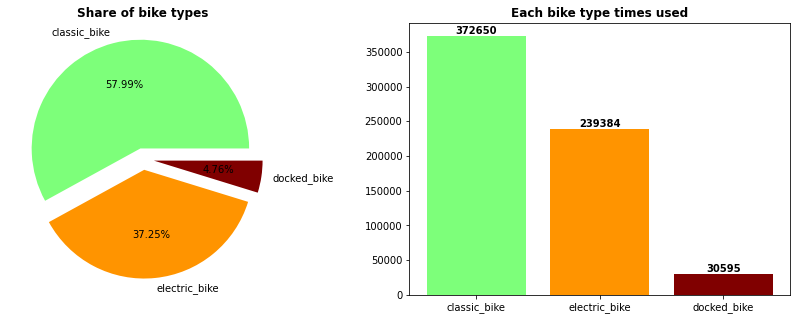

In [11]:
grouped=df['rideable_type'].value_counts().reset_index()

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.pie(grouped['rideable_type'],labels=grouped['index'],colors=[i for i in list(plt.get_cmap('jet')(np.linspace(0.5,1,3)))],
       explode=[0.1,0.1,0.1],autopct='%.2f%%')
ax1.set_title('Share of bike types', fontweight='bold')

ax2.bar(grouped['index'],grouped['rideable_type'],color=[i for i in list(plt.get_cmap('jet')(np.linspace(0.5,1,3)))])
def value_labels(y):
    for i in range(len(y)):
        plt.text(i,y.iloc[i],y.iloc[i],va='bottom',ha='center',fontweight='bold')
value_labels(grouped['rideable_type'])
ax2.set_title('Each bike type times used',fontweight='bold')

plt.show()

# average speed by bike type and membership status

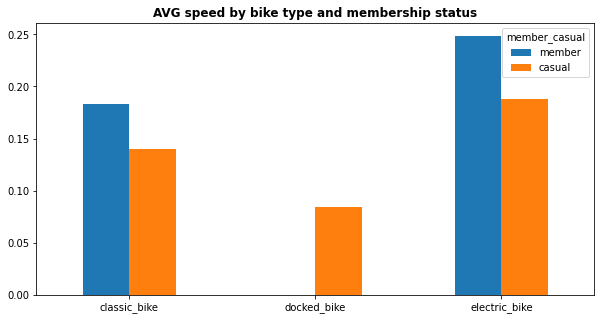

In [12]:
pivoted=df.pivot_table(index='rideable_type',columns='member_casual',values='speed',aggfunc='mean').reset_index()

fig,ax=plt.subplots()
pivoted.plot(ax=ax,kind='bar',x='rideable_type',y=['member','casual'],figsize=(10,5),xlabel='',rot=0)
plt.title('AVG speed by bike type and membership status',fontweight='bold')
plt.show()

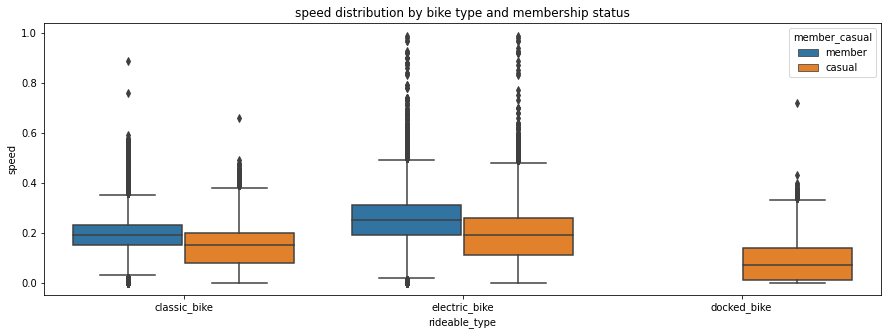

In [13]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df[df.speed<1],x='rideable_type',y='speed',hue='member_casual')
plt.title('speed distribution by bike type and membership status')
plt.show()

In [14]:
# seems customers with member status can't use docked_bikes.
# customers with member status ride bikes faster than casula customers. 
# electric bikes are the fastest bikes. docked bikes are the slowest

# Plot the distribution of location frequencies 

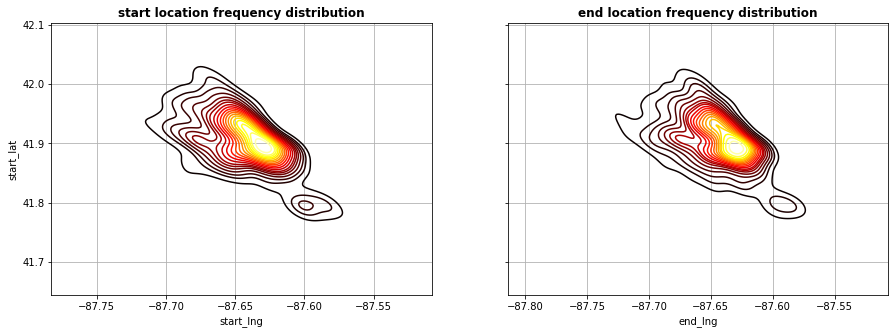

In [15]:
import random 

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5),sharey=True)

sns.kdeplot(ax=ax1,data=df.sample(n=1000),x='start_lng',y='start_lat',cmap='hot',levels=20)
ax1.set_title('start location frequency distribution',fontweight='bold')
ax1.grid()

sns.kdeplot(ax=ax2,data=df.sample(n=1000),x='end_lng',y='end_lat',cmap='hot',levels=20)
ax2.set_title('end location frequency distribution',fontweight='bold')
ax2.grid()

plt.show()

# Plot the destribution of speed frequencies 

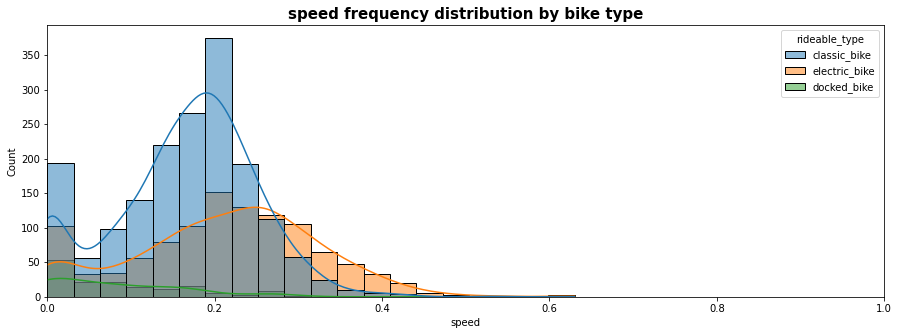

In [16]:
plt.figure(figsize=(15,5))
sns.histplot(data=df[df.speed<1].sample(n=3000),x='speed',hue='rideable_type',kde=True,bins=20)
plt.title('speed frequency distribution by bike type',size=15,fontweight='bold')
plt.xlim(0,1)
plt.show()

In [17]:
# speed frequency distribution follows normal distribution shape

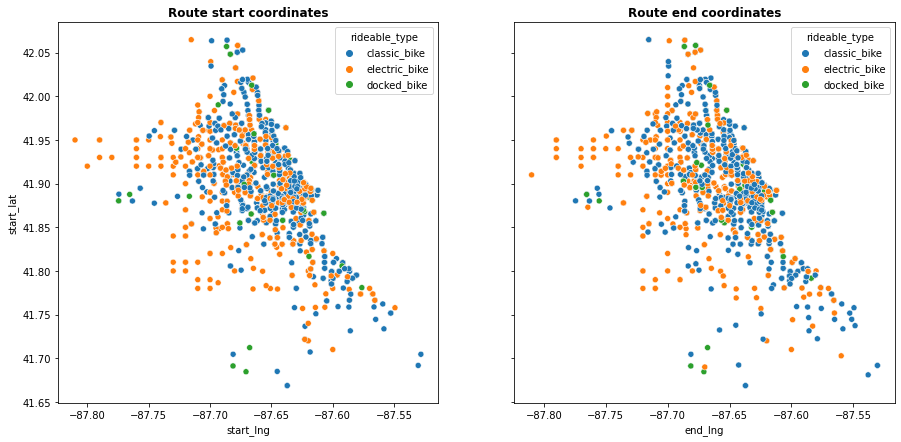

Average distance by bike type:  rideable_type
classic_bike     2.354615
docked_bike      2.397772
electric_bike    2.633903


In [18]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,7),sharey=True)
data=df.sample(n=10000)

sns.scatterplot(ax=ax1,data=data,x='start_lng',y='start_lat',hue='rideable_type')
ax1.set_title('Route start coordinates',fontweight='bold')

sns.scatterplot(ax=ax2,data=data,x='end_lng',y='end_lat',hue='rideable_type')
ax2.set_title('Route end coordinates',fontweight='bold')

plt.show()

print('Average distance by bike type: ',df.groupby('rideable_type')['distance_km'].mean().to_string())

# when are the bikes used most frequently for each day 

In [36]:
df['day_name']=pd.to_datetime(df.started_at).dt.day_name()
df['day']=pd.to_datetime(df.started_at).dt.day()
df['hour']=pd.to_datetime(df.started_at).dt.hour

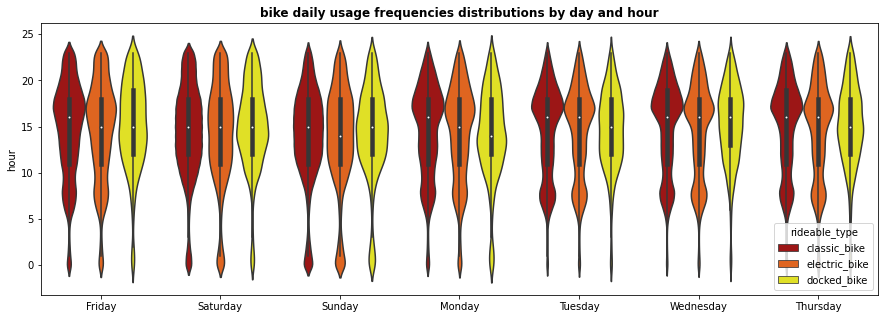

In [40]:
plt.figure(figsize=(15,5))
sns.violinplot(data=df.sort_values('day'),x='day_name',y='hour',palette='hot',hue='rideable_type')
plt.title('bike daily usage frequencies distributions by day and hour',fontweight='bold')
plt.xlabel('')
plt.show()

In [41]:
# each day bikes are more likely to be used between 11:00 and 17:00. 50 percent of daily rides are during this period.
# on weekends customers tend to use the bike any time of the day.